# 1016 Final Project: Sequence Length Warmup

Coding Reference:
- Pretrain GPT-2: https://huggingface.co/learn/nlp-course/chapter7/6
- Composer Warmup: https://github.com/mosaicml/composer

## CUDA
- Get GPU ready

In [ ]:
import sys
import os
import platform
import torch
import pandas as pd
import sklearn as sk
from tqdm import tqdm
import random
import wandb
from datetime import datetime
from datasets import load_dataset
from datasets import load_from_disk

max_sequence_length = 256
trial = 1
ep = 30

has_gpu = torch.cuda.is_available()
has_mps = torch.backends.mps.is_built()
device = "mps" if has_mps else "cuda" if torch.cuda.is_available() else "cpu"

print(f"Python Platform: {platform.platform()}")
print(f"PyTorch Version: {torch.__version__}")
print()
print(f"Python {sys.version}")
print(f"Pandas {pd.__version__}")
print(f"Scikit-Learn {sk.__version__}")
print("NVIDIA/CUDA GPU is", "available" if has_gpu else "NOT AVAILABLE")
print(f"Target device is {device}")
num_gpus = torch.cuda.device_count() if has_gpu else 0
print(f"Number of GPUs utilized: {num_gpus}")

In [ ]:
# function to track memory usage and prevent outofmem error
def check_cur_memory_percentage(device):
    total_mem = torch.cuda.get_device_properties(device).total_memory
    max_mem = torch.cuda.memory_allocated()
    return max_mem/total_mem

# Wikitext Model

## Download Dataset
- Use 'wikitext-2-v1' for now (smaller)
- If have time, may use 'wikitext-103-v1'

In [ ]:
# # download wikitext data and save it locally (only do this for the first time)
# save_path = ''
# dataset = load_dataset('wikitext', 'wikitext-2-raw-v1')
# dataset.save_to_disk(save_path)

In [ ]:
# load wikitext
load_path = 'C:\\Users\\Lucaw\\Desktop\\2024 Spring\\LLM\\wikitext-2-raw-v1'
ds = load_from_disk(load_path)

## Data Preprocessing
- Filter data by length (remove short lines and blanks)
- Tokenize sequences using GPT2 tokenizer fast

In [ ]:
# wikitext has lines with blank spaces or short titles, which are not suitable for training
# here we filter each line in wikitext by length
# any lines with length < 50 would be removed
num_proc = 10
def filter_dataset(dataset, min_len=1):
    """
    Filter a Dataset based on 'text' values not being blank and meeting a minimum length criteria.

    Args:
        dataset (Dataset): Input Dataset with 'text' values.
        min_length (int): Minimum length criteria for 'text' values. Default is 1.

    Returns:
        Filtered Dataset.
    """
    filtered_dataset = dataset.filter(lambda x: len(x['text'].strip()) >= min_len, num_proc=num_proc)
    return filtered_dataset

In [ ]:
# filter training, validation and testing set
filtered_train = filter_dataset(ds['train'], 50)
filtered_test = filter_dataset(ds['test'], 50)
filtered_validation = filter_dataset(ds['validation'], 50)

In [ ]:
# import GPT2TokenizerFast as the tokenizer
# padding token is defined as the <EOS> token
from transformers import GPT2TokenizerFast
tokenizer = GPT2TokenizerFast.from_pretrained("gpt2")
tokenizer.pad_token = tokenizer.eos_token

## Only run this part for the first time
- in this part, we tokenize data and store tokenized data locally for future use
- therefore, this part only needs to be executed once

In [ ]:
# from transformers import GPT2TokenizerFast
# class TokenizerWrapper:
#     def __init__(self, tokenizer):
#         self.tokenizer = tokenizer
    
#     def tokenize_function(self, examples):
#         return self.tokenizer(
#             examples["text"],
#             padding=False,
#             truncation=True,
#         )

# tokenizer = GPT2TokenizerFast.from_pretrained("gpt2")#, add_prefix_space=True
# tokenizer.pad_token = tokenizer.eos_token
# tokenizer_wrapper = TokenizerWrapper(tokenizer)

In [ ]:
# tokenized_path = 'C:\\Users\\Lucaw\\Desktop\\2024 Spring\\LLM\\tokenized-2'
# def tokenize_and_save(dataset, dataset_name):
#     tokenized_dataset = dataset.map(tokenizer_wrapper.tokenize_function, batched=True, num_proc = num_proc)
#     tokenized_dataset.save_to_disk(os.path.join(tokenized_path, dataset_name))

# num_proc = 4
# tokenize_and_save(filtered_train, 'train')
# tokenize_and_save(filtered_test, 'test')
# tokenize_and_save(filtered_validation, 'validation')

## Continued Data Preprocessing

In [ ]:
# now, load tokenized data from local
tokenized_path = 'C:\\Users\\Lucaw\\Desktop\\2024 Spring\\LLM\\tokenized-2'
tokenized_train = load_from_disk(os.path.join(tokenized_path, 'train'))
tokenized_test = load_from_disk(os.path.join(tokenized_path, 'test'))
tokenized_validation = load_from_disk(os.path.join(tokenized_path, 'validation'))

In [ ]:
# take a look
tokenized_train

In [ ]:
# here, we pre-process each sequence to make sure that they have the same length
# this enables batching for parallel compuation
def truncate_dataset(dataset, max_seq_len):
    """
    Combine and truncate a tokenized dataset based on maximum sequence length
    During the process, sequences will be combined together and interleaved with <EOS>
    e.g. Sequence1 <EOS> Sequenc2 <EOS> ... <EOS> SequenceN. This is a super long combined sequence.
    Then, we truncate the long sequence into length of maximum sequence length
    Note: the attention mask for <EOS> tokens would be 0. Otherwise, it would be 1.

    Args:
        dataset (Dataset): Input Tokenized Dataset 
        max_seq_len(int): Max Sequence Length

    Returns:
        Processed Dataset with input_ids and attention_masks.
    """
    
    # define split and shuffle function to be mapped (default batch size = 1000)
    def combine_and_truncate(batch):
        # set empty list to store splitted sequence
        tokens = []
        attentions = []
        padding_token_id = tokenizer.pad_token_id

        for sequence in batch['input_ids']:
            piece = sequence + [padding_token_id]
            attention = [1] * len(sequence)
            attention += [0]
            tokens += piece
            attentions += attention

        length = len(tokens) // max_seq_len * max_seq_len

        input_ids = []
        attention_masks = []
        for i in range(0, length, max_seq_len):
            input_ids.append(tokens[i:i+max_seq_len])
            attention_masks.append(attentions[i:i+max_seq_len])

        return {'input_ids': input_ids, 'attention_mask': attention_masks}

    # map the split_and_shuffle function to batches
    truncated_dataset = dataset.map(combine_and_truncate, batched=True, remove_columns=dataset.column_names)
    return truncated_dataset

In [ ]:
# combine and truncate train, test and eval
truncated_train = truncate_dataset(tokenized_train, max_sequence_length)
truncated_test = truncate_dataset(tokenized_test, max_sequence_length)
truncated_eval = truncate_dataset(tokenized_validation, max_sequence_length)

In [ ]:
truncated_train

In [ ]:
# # check the nth element of truncated_train
# idx = 0
# print(truncated_train[idx]['input_ids'])
# print(truncated_train[idx]['attention_mask'])
# tokenizer.decode(truncated_train[idx]["input_ids"])

## Model Building
- Set model configuration
- Set data collator and data loader
- Convert model to ComposeModel instance
- Try original model, sequence warmup, and non-linear sequence warmup

In [ ]:
# create data collator
from transformers import DataCollatorForLanguageModeling
data_collator = DataCollatorForLanguageModeling(tokenizer, mlm=False)

In [ ]:
# create data loader with batch_size = 64
from torch.utils.data import DataLoader
train_dataloader = DataLoader(truncated_train, batch_size=64, collate_fn=data_collator, drop_last = True)
test_dataloader = DataLoader(truncated_test, batch_size=64, collate_fn=data_collator, drop_last = True)
eval_dataloader = DataLoader(truncated_eval, batch_size=64, collate_fn=data_collator, drop_last = True)

In [ ]:
# set model configuration. We use GPT-2 Small architecture.
from transformers import GPT2LMHeadModel, AutoConfig

config = AutoConfig.from_pretrained(
    "gpt2",
    vocab_size=len(tokenizer),
    n_ctx=max_sequence_length,
    bos_token_id=tokenizer.bos_token_id,
    eos_token_id=tokenizer.eos_token_id,
    max_position_embeddings=max_sequence_length
)

## Trials:
- Trial 1: Original model with fixed sequence length
- Trial 2: Model w/ linear warmup, implemented by Composer.algorithms.SeqLengthWarmup
- Trial 3: Model w/ non-linear (exponential) warmup, with modified code on Composer library
- Trial 4: Model w/ non-linear (logarithmic) warmup, with modified code on Composer library

For each trail, the model has maximum sequence length of 128 and is trained for 3 epochs. The evaluation metrices are CrossEntropy and Perplexity. The training and evaluation loss are plotted on https://wandb.ai/site

### Trial 1: Original Model

In [ ]:
# create model
model = GPT2LMHeadModel(config)
model.to(device)

In [ ]:
# convert model to ComposeModel instance
from composer.metrics.nlp import LanguageCrossEntropy, LanguagePerplexity
from composer.models.huggingface import HuggingFaceModel

metrics = [
    LanguageCrossEntropy(ignore_index=-100),
    LanguagePerplexity(dist_sync_on_step=False)
]

# package as a Composer model
composer_model_original = HuggingFaceModel(model, tokenizer=tokenizer, metrics=metrics, use_logits=True)

In [ ]:
# set trainer and train the model
from composer.trainer import Trainer
from composer.loggers import WandBLogger

current_date = datetime.now()
formatted_date = current_date.strftime('%m%d')
max_duration = ep

wandb_logger = WandBLogger(
    project='sequence-length-warmup', 
    entity='lucawangnfls',
    name=f'T-{trial}-{formatted_date}-{max_duration}e-{max_sequence_length}l')

trainer = Trainer(
    model=composer_model_original,
    train_dataloader=train_dataloader,
    eval_dataloader=eval_dataloader,
    eval_interval="50ba",
    max_duration=max_duration,
    log_to_console=True,
    progress_bar=False,
    console_log_interval='200ba',
    loggers=wandb_logger
)

In [ ]:
check_cur_memory_percentage('cuda')

In [ ]:
trainer.fit()

In [ ]:
# clean-up GPU storage
import gc

print("Before Cleaning: ", check_cur_memory_percentage('cuda'))
model = composer_model_original.model

del trainer
del train_dataloader
del composer_model_original

gc.collect()
torch.cuda.empty_cache()
print("After Cleaning: ", check_cur_memory_percentage('cuda'))

### Trial 2: Linear Warmup

In [ ]:
# create model
model = GPT2LMHeadModel(config)
model.to(device)

In [ ]:
# convert model to ComposeModel instance
from composer.metrics.nlp import LanguageCrossEntropy, LanguagePerplexity
from composer.models.huggingface import HuggingFaceModel

metrics = [
    LanguageCrossEntropy(ignore_index=-100),
    LanguagePerplexity(dist_sync_on_step=False)
]

# package as a Composer model
composer_model_linear = HuggingFaceModel(model, tokenizer=tokenizer, metrics=metrics, use_logits=True)

In [ ]:
# set trainer and train the model
from composer.trainer import Trainer
from composer.loggers import WandBLogger

current_date = datetime.now()
formatted_date = current_date.strftime('%m%d')
max_duration = ep

wandb_logger = WandBLogger(
    project='sequence-length-warmup', 
    entity='lucawangnfls',
    name=f'T-{trial}-{formatted_date}-{max_duration}e-{max_sequence_length}l')

In [ ]:
from composer.algorithms import SeqLengthWarmup
seq_length_warmup = SeqLengthWarmup(duration=0.3,
                                    min_seq_length=4,
                                    max_seq_length=max_sequence_length,
                                    step_size=4,
                                    truncate=True,
                                    preserve_end_of_sequence=False)

trainer = Trainer(
    model=composer_model_linear,
    train_dataloader=train_dataloader,
    eval_dataloader=eval_dataloader,
    eval_interval="50ba",
    max_duration=max_duration,
    algorithms=[seq_length_warmup],
    log_to_console=True,
    progress_bar=False,
    console_log_interval='200ba',
    loggers=wandb_logger
)

In [ ]:
trainer.fit()

In [ ]:
# clean-up GPU storage
import gc

print("Before Cleaning: ", check_cur_memory_percentage('cuda'))
model = composer_model_linear.model

del trainer
del train_dataloader
del composer_model_linear

gc.collect()
torch.cuda.empty_cache()
print("After Cleaning: ", check_cur_memory_percentage('cuda'))

### Trial 3: Non-Linear Warmup

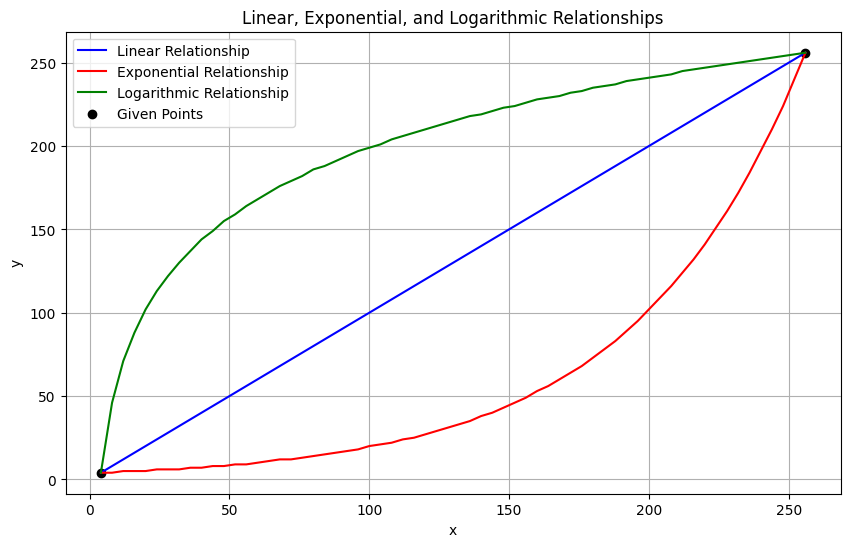

In [13]:
# Firstly, let's get the exponential_relationship and logarithmic_relationship
import numpy as np
import matplotlib.pyplot as plt

# Given points
x1, y1 = 4, 4
x2, y2 = 256, 256

# Linear relationship
linear_relationship = np.linspace(4, 256, 64)

# Exponential relationship
# y = a * b^x
# Using the given points to solve for 'a' and 'b'
b_exp = (y2 / y1) ** (1 / (x2 - x1))
a_exp = y1 / (b_exp ** x1)
exponential_relationship = a_exp * (b_exp ** linear_relationship)
exponential_relationship = [int(round(x)) for x in exponential_relationship]

# Logarithmic relationship
# y = a + b * log(x)
# Using the given points to solve for 'a' and 'b'
b_log = (y2 - y1) / (np.log(x2) - np.log(x1))
a_log = y1 - b_log * np.log(x1)
logarithmic_relationship = a_log + b_log * np.log(linear_relationship)
logarithmic_relationship = [int(round(x)) for x in logarithmic_relationship]

# Plotting
plt.figure(figsize=(10, 6))

plt.plot(linear_relationship, linear_relationship, label='Linear Relationship', color='blue')
plt.plot(linear_relationship, exponential_relationship, label='Exponential Relationship', color='red')
plt.plot(linear_relationship, logarithmic_relationship, label='Logarithmic Relationship', color='green')

plt.scatter([x1, x2], [y1, y2], color='black', label='Given Points')

plt.xlabel('x')
plt.ylabel('y')
plt.title('Linear, Exponential, and Logarithmic Relationships')
plt.legend()
plt.grid(True)

plt.show()

In [14]:
linear_relationship

array([  4.,   8.,  12.,  16.,  20.,  24.,  28.,  32.,  36.,  40.,  44.,
        48.,  52.,  56.,  60.,  64.,  68.,  72.,  76.,  80.,  84.,  88.,
        92.,  96., 100., 104., 108., 112., 116., 120., 124., 128., 132.,
       136., 140., 144., 148., 152., 156., 160., 164., 168., 172., 176.,
       180., 184., 188., 192., 196., 200., 204., 208., 212., 216., 220.,
       224., 228., 232., 236., 240., 244., 248., 252., 256.])

In [15]:
exponential_relationship

[4,
 4,
 5,
 5,
 5,
 6,
 6,
 6,
 7,
 7,
 8,
 8,
 9,
 9,
 10,
 11,
 12,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 20,
 21,
 22,
 24,
 25,
 27,
 29,
 31,
 33,
 35,
 38,
 40,
 43,
 46,
 49,
 53,
 56,
 60,
 64,
 68,
 73,
 78,
 83,
 89,
 95,
 102,
 109,
 116,
 124,
 132,
 141,
 151,
 161,
 172,
 184,
 197,
 210,
 224,
 240,
 256]

In [ ]:
# create model
model = GPT2LMHeadModel(config)
model.to(device)

In [ ]:
# convert model to ComposeModel instance
from composer.metrics.nlp import LanguageCrossEntropy, LanguagePerplexity
from composer.models.huggingface import HuggingFaceModel

metrics = [
    LanguageCrossEntropy(ignore_index=-100),
    LanguagePerplexity(dist_sync_on_step=False)
]

# package as a Composer model
composer_model_nonlinear = HuggingFaceModel(model, tokenizer=tokenizer, metrics=metrics, use_logits=True)

In [ ]:
# set trainer and train the model
from composer.trainer import Trainer
from composer.loggers import WandBLogger

current_date = datetime.now()
formatted_date = current_date.strftime('%m%d')
max_duration = ep

wandb_logger = WandBLogger(
    project='sequence-length-warmup', 
    entity='lucawangnfls',
    name=f'T-{trial}-{formatted_date}-{max_duration}e-{max_sequence_length}l')

#### Modify Source Code of Composer Library to Enable Non-Linear Warmup 

In [ ]:
# self-defined subclass that modify arguments and functions of composer.algorithms.SeqLengthWarmup class
# the modifications are only applied to __init__ and apply()
# the basic idea is to replace the linear warmup curve with non-linear curves
# the original max_seq_len, min_seq_len and step_size arguments are removed
# add a 'curve' argument, which is a list that represents the changing curve of warmup sequence length

from composer.algorithms.seq_length_warmup.seq_length_warmup import SeqLengthWarmup, set_batch_sequence_length
from typing import Dict, Mapping, Optional
from composer.core import Algorithm, Batch, Event, State, TimeUnit, get_precision_context
from composer.loggers import Logger

class MySeqLengthWarmup(SeqLengthWarmup):
    def __init__(
        self,
        duration: float = 0.3,
        max_seq_length: int = 256,
        curve: list = range(256),
        truncate: bool = True,
        preserve_end_of_sequence: bool = False,
    ):
        self.duration = duration
        self.max_seq_length = max_seq_length
        self.curve = curve
        self.truncate = truncate
        self.preserve_end_of_sequence = preserve_end_of_sequence

        if self.duration < 0 or self.duration > 1:
            raise ValueError(f'Duration must be between 0 and 1, got: {self.duration}')
            
        self._activated = False
        self._original_model = None

    def apply(self, event: Event, state: State, logger: Logger) -> Optional[int]:
        if event == Event.INIT:
            if not isinstance(state.model, HuggingFaceModel):
                raise RuntimeError(
                    textwrap.dedent(
                        f"""\
                    {type(self).__name__} requires state.model to be of type {HuggingFaceModel.__name__}, not of type {type(state.model)}""",
                    ),
                )

            self._original_model = state.model
            return

        assert state.dataloader is not None, 'dataloader should be set on AFTER_DATALOADER'
        assert state.max_duration is not None, 'max_duration should be set on AFTER_DATALOADER'

        # in order to avoid OOMs, we do a forward and a backward pass on a dummy input.
        if not self._activated:
            self._activate_model(state, logger)

        if state.max_duration.unit == TimeUnit.EPOCH:
            if state.dataloader_len is None:
                raise RuntimeError('Sequential Length Warmup requires the dataloader to be sized.')
            num_optimization_steps = int(state.dataloader_len) * state.max_duration.value
        elif state.max_duration.unit == TimeUnit.BATCH:
            num_optimization_steps = state.max_duration.value
        else:
            raise NotImplementedError(
                textwrap.dedent(
                    """\
                    To use sequential length warmup, the max_duration must be in epochs or batches.
                    Specifying the `max_duration` in tokens or samples for use with sequential
                    length warmup will be supported in a future Composer release. See
                    https://github.com/mosaicml/composer/issues/226.""",
                ),
            )
        num_warmup_steps = int(num_optimization_steps * self.duration)  # in batches

        # assume the full sequence length is the unaltered sequence length
        num_update_steps = len(self.curve)
        update_every_n_steps = num_warmup_steps // num_update_steps

        curve_idx = int(state.timestamp.batch) // update_every_n_steps

        if curve_idx >= num_update_steps:
            curr_seq_len = self.max_seq_length
        else:
            curr_seq_len = self.curve[int(state.timestamp.batch) // update_every_n_steps] 

        state.batch = set_batch_sequence_length(state.batch, curr_seq_len, self.truncate, self.preserve_end_of_sequence)

        batch_size = state.batch['input_ids'].shape[0]
        logger.log_metrics({
            'seq_length_warmup/curr_seq_len': curr_seq_len,
            'seq_length_warmup/curr_bs': batch_size,
        })

In [ ]:
if trial == 3:
    distiabution = exponential_relationship
else:
    distribution = logarithmic_relationship

seq_length_warmup = MySeqLengthWarmup(duration=0.3,
                                      max_seq_length = max_sequence_length,
                                      curve=distribution,
                                      truncate=True,
                                      preserve_end_of_sequence=False)

trainer = Trainer(
    model=composer_model_nonlinear,
    train_dataloader=train_dataloader,
    eval_dataloader=eval_dataloader,
    eval_interval="50ba",
    max_duration=max_duration,
    algorithms=[seq_length_warmup],
    log_to_console=True,
    progress_bar=False,
    console_log_interval='200ba',
    loggers=wandb_logger
)

In [ ]:
trainer.fit()

In [ ]:
# clean-up GPU storage
import gc

print("Before Cleaning: ", check_cur_memory_percentage('cuda'))
model = composer_model_nonlinear.model

del trainer
del train_dataloader
del composer_model_nonlinear

gc.collect()
torch.cuda.empty_cache()
print("After Cleaning: ", check_cur_memory_percentage('cuda'))